%%latex
\tableofcontents 
\setcounter{section}{0}

# Review 
In the last notebook the semiconductor part of the SMOX grains was addressed. This included the numerical calculation the charge carrier density as as function of the conduction band bending. Additionally the Poisson equation for spherical grains was solved.
The grain results are saved to file and can now be here used again.
Additionally a Python module was created. In this module all the parts we need to recycle from the previous notebook are merged together.
By merging the relevant classes and functions into on python file, the command:
`from part2 import *`
will execute all the commands in this file and add them to the main namespace. By this the classes `material` and `grain` will again be available for further evaluations.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from part2 import *



# Load the results

In [4]:
calc_dF = pd.read_hdf('results.h5', 'raw')
calc_dF.index = range(len(calc_dF))

In [5]:
def create_grain_from_data(dF):
    if type(dF)==pd.Series:
        dF = pd.DataFrame([dF])
        
    if len(dF['temp'].unique())==1:
        T_C = dF['temp'].unique()[0]
    else:
        raise Exception('Multiple paramters for one grain are invalid.')
    
    if len(dF['ND'].unique())==1:
        ND = dF['ND'].unique()[0]
    else:
        raise Exception('Multiple paramters for one grain are invalid.')
    
    if len(dF['mass_eff'].unique())==1:
        mass_e_eff_factor = dF['mass_eff'].unique()[0]/CONST.MASS_E 
    else:
        raise Exception('Multiple paramters for one grain are invalid.')
    
    if len(dF['R'].unique())==1:
        grainsize_radius = dF['R'].unique()[0]
    else:
        raise Exception('Multiple paramters for one grain are invalid.')
        

    EDCF_eV = calc_EDCF_by_temp(T_C, ND, mass_e_eff_factor)

    material = Material(T_C,DIFF_EF_EC_evolt=EDCF_eV)
    grain = Grain(grainsize_radius=grainsize_radius,material=material)
    
    return grain


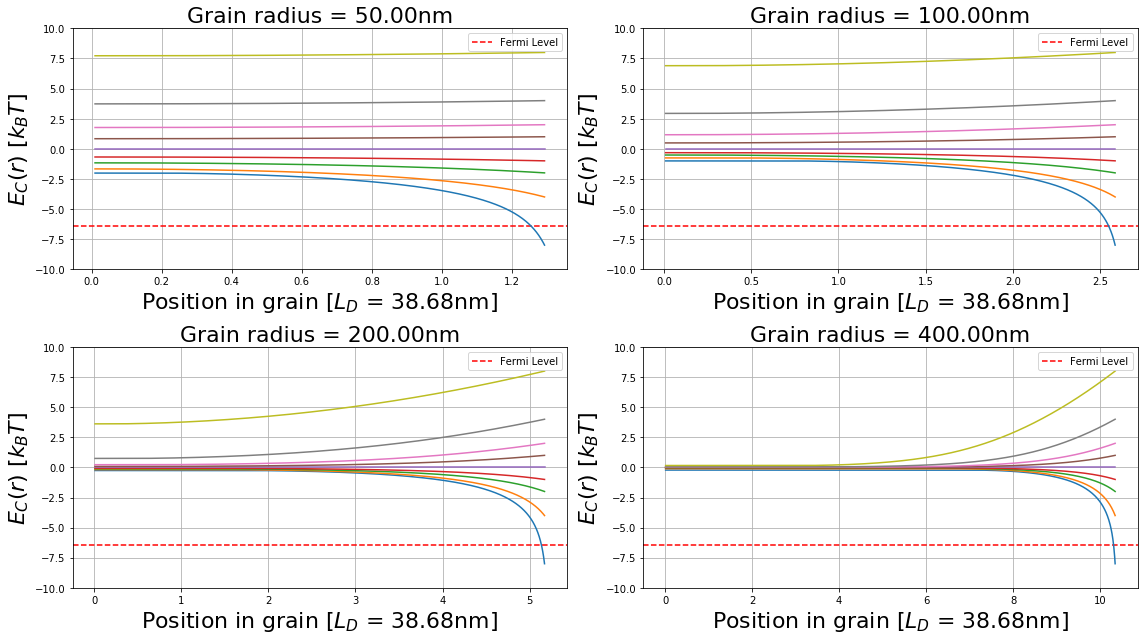

In [6]:
fig, axes= subplots(2,2,figsize = (16,9))
for ax_i, (R, calc_dF_grainsize) in enumerate(calc_dF.groupby('R')):
    axe = fig.axes[ax_i]

    grain = create_grain_from_data(calc_dF_grainsize)
    

    axe.axhline(-grain.material.J_to_kT(grain.material.Diff_EF_EC),
                linestyle='--',color='r', label='Fermi Level')
    axe.set_ylim(-10,10)

    for vinit, ser_temp in calc_dF_grainsize.iterrows():

        r = ser_temp['r']
        v = ser_temp['v']
        vdot = ser_temp['v_dot']

        axe.set_title(f'Grain radius = {grain.R*1e9:.2f}nm', fontsize=22)
        
        axe.plot(r,v, '-', label = "")
        axe.set_ylabel('$E_C(r)$ [$k_BT$]', fontsize =22)
        axe.set_xlabel(f'Position in grain [$L_D$ = {grain.material.LD*1e9:.2f}nm]',
                       fontsize =22)
    axe.legend()
    axe.grid(b=True)
fig.tight_layout()


This graph shows how a surface potential is shielded by the remaining ionized donors. In the case of on deletion layer ( $E_{C_{Surface}}>0 )$), the total number of charges shielding the surface potential is rather small compared to the amount of charges in an accumulation layer ( $E_{C_{Surface}}<0 )$). The result of such an asymmetry is visible in the graph. The width of the accumulation layer is by far smaller then the width of the depleted are.

# From charge distribution to resistance

With the previous tools and calculation it is now possible to assign each point inside the grain a certain charge density. From this charge density a specific resistivity can be assinged to this area.
First the ratio of $\frac{n(r)}{n_b}$ inside the grain will be represented for the different starting conditions regarding $E_{C_{Surface}}$.
To evaluate the $n(r)$ at arbitrary points r inside the grain, one additional step is needed. To calculate values between the points, where already solution exist, the additional value can be retrieved by interpolating between the neighbors. This process is generally called interpolation. Again, SciPy and Python offer here also a easy to use and robust solution.
`from scipy import interpolate` adds the `interpolate` module into the kernel. The `interp1d` function of this module is described ([here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.htm)) as follows:
>Interpolate a 1-D function.
>
>x and y are arrays of values used to approximate some function f: y = f(x). This class returns a function whose call method uses interpolation to find the value of new points.

This is how the function will be used for our needs. First we select one of the initial parameters for $E_{init}$ and $E_{dot_{init}}$ to recalculate the solution of the Poisson equation with these correct start parameters. In a second step we use `interp1d` to create a function which uses an interpolation algorithm to find the right value for any position inside the grain.

In [7]:
from scipy import interpolate
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

def get_interpolated_n_v(ser,grain):
    
    v = ser['v']
    r = ser['r']
    n = ser['n']
    
    r[0] = 0
    
    n_int = interpolate.interp1d(r*grain.material.LD, n, kind='linear')
    v_int = interpolate.interp1d(r*grain.material.LD, v, kind='linear')
    
    return n_int, v_int

## The "numerical" grain
With the gain in information from the last notebook, we can calculate the number of free charge carriers 

![Numerical Grain](media/pics/sliced_cube.png)

In [8]:
def pos_to_r(xi,yi,grain, d):
    dx = 2*grain.R/d.shape[0]
    cx = d.shape[0]//2
    cy = d.shape[1]//2
    ri = ((xi-cx)**2+(yi-cy)**2)**0.5
    return(ri*dx)


def create_numerical_grain_matrix( grain, ser,size_n=100,):
    n_int, v_int = get_interpolated_n_v(ser, grain)
    nx = ny = size_n

    
    d_v = np.zeros((2*nx+1,2*ny+1))
    d_cond = np.zeros((2*nx+1,2*ny+1))
    d_mask = np.zeros((2*nx+1,2*ny+1))
    

    for xi in range(d_cond.shape[0]):
        for yi in range(d_cond.shape[1]):
            r = float(pos_to_r(xi,yi,grain, d_cond))
            try:
                condu = n_int(r)/grain.material.nb
                d_cond[xi, yi] = condu
                d_mask[xi,yi] = 1

            except ValueError:
                #outside the grain
                d_cond[xi, yi] = 0
                d_mask[xi,yi] = 0
    return d_v, d_cond, d_mask

## Precalc the numerical grains for all conditions

In [119]:
for i, ser in calc_dF.iterrows():
    print(f'Initalized {i+1} of {len(calc_dF)}.', end='\r')
    grain = create_grain_from_data(ser)
    d_v, d_cond,d_mask = create_numerical_grain_matrix( grain, ser,size_n=100)
    d_cond_plot = d_cond.copy()
    d_cond_plot[np.where(d_mask==0)]=None
    calc_dF.loc[ser.name, 'd_cond'] = [d_cond_plot]

In [125]:
%matplotlib inline

This means in the accumulation layer there are a the specific position 5.39 times more free charge carriers available as in the center. This results directly in a lower resistivity of the same factor.
Instead of just calculating just individual values, the graphical representation is in this case more helpful.

In [126]:

def plot_grain_states(calc_dF_grainsize, vmax=None, vmin=None):
    fig, axes = subplots(3,3, figsize = (16,9))
    
    grain = create_grain_from_data(calc_dF_grainsize)

    for ax_i, (vinit, ser) in enumerate(calc_dF_grainsize.iterrows()):
        axe = fig.axes[ax_i]
        
        Einit_kT = ser['Einit_kT']

        axe.set_title(r'$E_{C_{Surface}}=$'+f'{Einit_kT}kT')
        axe.set_ylabel('x [nm]')
        axe.set_xlabel('y [nm]')
        
        d_cond_plot = calc_dF.loc[ser.name, 'd_cond']
        im = axe.imshow(np.log(d_cond_plot), interpolation='bicubic',
                        extent=(-grain.R*1e9, grain.R*1e9, -grain.R*1e9, grain.R*1e9),
                        vmax=vmax, vmin=vmin, cmap='hot')
    fig.tight_layout()
    


def plot_currents(GrainRadius):
    R = GrainRadius/1e9
    calc_dF_grainsize = calc_dF.groupby('R').get_group(R)
    max_n = np.log(calc_dF_grainsize['d_cond'].apply(lambda r:np.nanmax(r))).max()
    min_n = np.log(calc_dF_grainsize['d_cond'].apply(lambda r:np.nanmin(r))).min()
    print(max_n, min_n)
    
    plot_grain_states(calc_dF_grainsize, vmax = max_n, vmin = min_n)

grainsizes = list(calc_dF['R'].unique())
interact(plot_currents, GrainRadius=np.array(grainsizes)*1e9, text='Select a grainsize:');

interactive(children=(Dropdown(description='GrainRadius', options=(50.0, 100.0, 200.0, 400.0), value=50.0), Ou…

# Relaxation

In [71]:
calc_dF.to_hdf('size_test_delete_please.h5', 'raw')

/usr/lib/python3.8/site-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['n', 'r', 'v', 'v_dot', 'd_cond']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [68]:
from scipy import signal


def initaliz_d_v(d_v):
    d_v[:,0] = -1000
    d_v[:,-1] = +1000
    d_v = d_v*d_mask
    return d_v

def solve_relaxation(d_v, d_cond, d_mask):
    res_new = 1000
    for i in range(300000):

        conv = [[0,1,0],[1,0,1],[0,1,0]]
        numerator = signal.convolve2d(d_v*d_cond, conv, boundary='fill',
                                      mode='same', fillvalue=0)
        denominator = signal.convolve2d(d_cond, conv, boundary='fill',
                                        mode='same', fillvalue=0)
        d_v_new = (numerator/denominator)*d_mask
        d_v_new = np.nan_to_num(d_v_new,0)

        d_v_prev = d_v.copy()
        

        
        d_v = d_v_new.copy()
        d_v = initaliz_d_v(d_v)

        res_pre = res_new
        res_new = np.abs(np.sum(d_v_prev-d_v))

        if i%10000==1:
            print(res_pre,res_new)
            
            if ((res_pre - res_new)==0) and (i>40000):
                break
            
    return d_v, d_cond, d_mask

def plot_num_grain(d_v, d_cond, d_mask):
    fig, axes =subplots(1,3)
    d_v_plot = d_v.copy()
    d_v_plot[np.where(d_mask==0)]=None

    axes[0].imshow(d_mask)
    axes[1].imshow(d_cond)
    axes[2].imshow(d_v_plot,interpolation= 'nearest')
    
def plot_voltage_1d(d_v):
    fig, axe = subplots()
    center = d_v[d_v.shape[0]//2,:]
    axe.plot(center)

def calc_current_center(d_v, d_cond, d_mask):
    center_pos = d_v.shape[0]//2
    center_current = (d_v[:,center_pos+1]-d_v[:,center_pos-1])*d_cond[:,center_pos]
    
    r = np.array([float(pos_to_r(xi,center_pos,grain, d_v)) for xi in range(len(center_current))])
    
    center_current_tot = np.sum(center_current*r*2*pi)
    return center_current_tot, center_current, r

def plot_center_current(r, center_current):
    fig, axe = subplots()
    axe.plot(r*1e9,center_current)
    return

#vinit, current = calc_current(d_v, d_cond, d_mask)

In [ ]:
calc_dF['current'] = None

In [ ]:


def initaliz_d_v(d_v):
    d_v[:,0] = -1000
    d_v[:,-1] = +1000
    d_v = d_v*d_mask
    return d_v


#for vinit, ser in calc_dF.iterrows():
calc_dFs = {}
for size_n in [10,20,40]:
    c_dF = calc_dF.copy()
    for i, (ind,ser) in enumerate(c_dF.iterrows()):

        print(f'Initalized {i+1} of {len(c_dF)}.')
        vinit = ser.name

        grain = create_grain_from_data(ser)

        d_v, d_cond, d_mask = create_numerical_grain_matrix( grain, ser,size_n=50,)
        d_v = initaliz_d_v(d_v)

        d_v, d_cond, d_mask = solve_relaxation(d_v, d_cond, d_mask)

        center_current_tot, center_current, r = calc_current_center(d_v, d_cond, d_mask)

        #plot_num_grain(d_v, d_cond, d_mask)
        #plot_voltage_1d(d_v)
        #plot_center_current(r, center_current)


        c_dF.loc[vinit, 'current'] = center_current_tot
    calc_dFs[size_n] = c_dF

Initalized 1 of 36.
2.8421709430404007e-13 3.979039320256561e-13


<ipython-input-68-1b3f12e4d0a4>:19: RuntimeWarning: invalid value encountered in true_divide
  d_v_new = (numerator/denominator)*d_mask


5.597540660151612e-12 4.576233489372861e-12
1.534220671242214e-11 1.3914914007281606e-12
4.470048746920325e-12 9.824756458610649e-13
1.2982962227449369e-12 4.9067444464892115e-12
6.310799948503871e-12 8.070782245840193e-12
5.259566807207092e-13 5.955744226087447e-12
1.9950305793247724e-15 1.9950305793247724e-15
Initalized 2 of 36.
5.684341886080802e-14 2.5579538487363607e-13
2.7046333922475796e-13 2.5238413789430147e-12
6.63237348003695e-12 4.1252248538241505e-12
1.516062844756055e-12 2.4874125565111813e-12
7.101240957025582e-12 1.0338585944288182e-11
4.50583091424989e-13 3.977558506897941e-12
7.02315082651593e-13 7.02315082651593e-13
Initalized 3 of 36.
5.684341886080802e-14 1.9895196601282805e-13
5.085846674357519e-12 6.41049409735861e-12
3.456375115995112e-13 3.5217435250586154e-12
1.6061205840230561e-12 5.265787746054825e-12
2.5473353840283703e-13 3.720782808063357e-12
2.378961624638754e-12 1.986330415174384e-13
1.362542829301528e-15 1.362542829301528e-15
Initalized 4 of 36.
2.8421

In [52]:
1e-50

1e-50

In [86]:
len(calc_dFs[10])

36

In [77]:
currents = []
sizes = [10,20,40]
calc_dFs_temp = {}

for size_n in sizes:
    calc_dF_grainsize = calc_dF[calc_dF['R']==400e-9].copy()
    
    for i, (ind,ser) in enumerate(calc_dF_grainsize.iterrows()):
        print(f'Initalized {i+1} of {len(calc_dF_grainsize)}.')
        vinit = ser.name

        grain = create_grain_from_data(ser)
        d_v, d_cond, d_mask = create_numerical_grain_matrix( grain, ser,size_n=size_n,)
        d_v = initaliz_d_v(d_v)

        d_v, d_cond, d_mask = solve_relaxation(d_v, d_cond, d_mask)

        center_current_tot, center_current, r = calc_current_center(d_v, d_cond, d_mask)


        #plot_num_grain(d_v, d_cond, d_mask)
        #plot_voltage_1d(d_v)
        #plot_center_current(r, center_current)

        calc_dF_grainsize.loc[vinit, 'current'] = center_current_tot
        calc_dFs_temp[size_n] = calc_dF_grainsize

Initalized 1 of 9.
1.1368683772161603e-13 5.684341886080802e-14


<ipython-input-68-1b3f12e4d0a4>:19: RuntimeWarning: invalid value encountered in true_divide
  d_v_new = (numerator/denominator)*d_mask


4.793605426475293e-13 4.793605426475293e-13
4.793605426475293e-13 4.793605426475293e-13
4.793605426475293e-13 4.793605426475293e-13
4.793605426475293e-13 4.793605426475293e-13
Initalized 2 of 9.
1.1368683772161603e-13 1.1368683772161603e-13
1.8894042537293402e-15 1.8894042537293402e-15
1.8894042537293402e-15 1.8894042537293402e-15
1.8894042537293402e-15 1.8894042537293402e-15
1.8894042537293402e-15 1.8894042537293402e-15
Initalized 3 of 9.
5.684341886080802e-14 0.0
3.07993144208335e-14 3.07993144208335e-14
3.07993144208335e-14 3.07993144208335e-14
3.07993144208335e-14 3.07993144208335e-14
3.07993144208335e-14 3.07993144208335e-14
Initalized 4 of 9.
0.0 5.684341886080802e-14
5.216635118676067e-14 5.216635118676067e-14
5.216635118676067e-14 5.216635118676067e-14
5.216635118676067e-14 5.216635118676067e-14
5.216635118676067e-14 5.216635118676067e-14
Initalized 5 of 9.
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
Initalized 6 of 9.
2.842170943040401e-14 2.842170943040401e-14
1.74822251608639e-1

In [74]:
data

{}

In [88]:
calc_dFs[10]['current']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
8              NaN
9              NaN
10             NaN
11             NaN
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
17             NaN
18             NaN
19             NaN
20             NaN
21             NaN
22             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
30             NaN
31             NaN
32             NaN
33             NaN
34             NaN
35    4.747934e-09
Name: current, dtype: float64

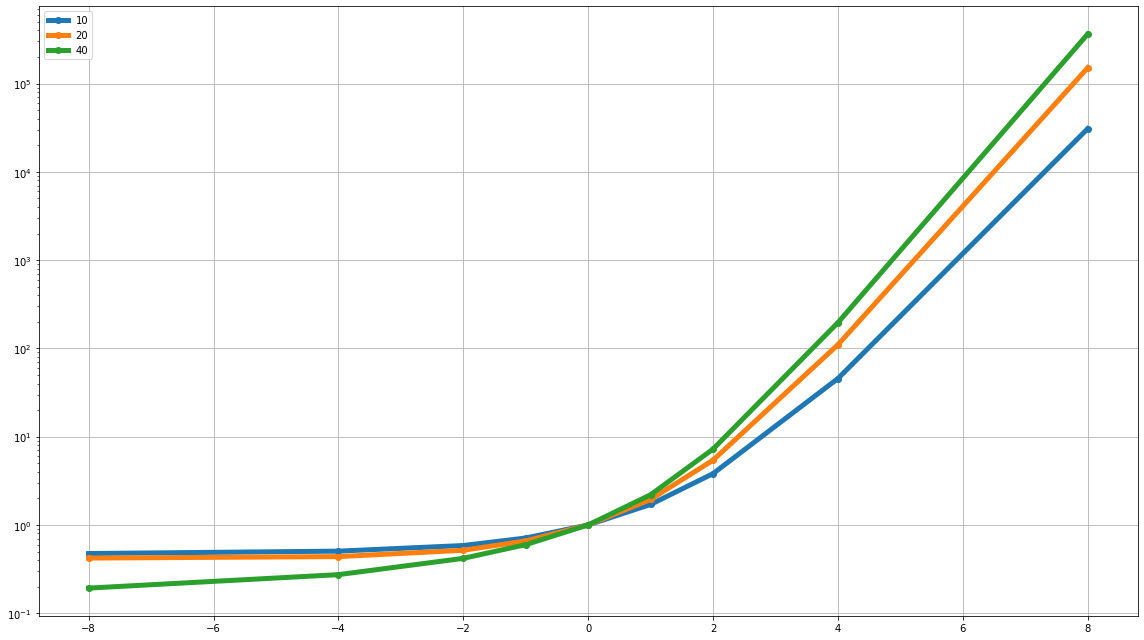

In [78]:
for size_n,calc_dF_n in calc_dFs.items():
    fig, axe = subplots(figsize = (16,9))
    
    for ax_i, (R,calc_dF_grainsize) in enumerate(calc_dF_n.groupby('R')):

        flat_band = calc_dF_grainsize[calc_dF_grainsize['Einit_kT']==0].iloc[0]['current']
        res = flat_band/calc_dF_grainsize['current']
        v = calc_dF_grainsize['Einit_kT']
        axe.plot(v, res, 'o-', label = f'{size_n}', linewidth=5)
        axe.set_yscale('log')
        axe.grid(b=True)

    fig.tight_layout()
    axe.legend()


In [ ]:
for i, ser in calc_dF.iterrows():
    print(f'Initalized {i+1} of {len(calc_dF)}.', end='\r')
    grain = create_grain_from_data(ser)
    d_v, d_cond,d_mask = create_numerical_grain_matrix( grain, ser,size_n=100)
    d_cond_plot = d_cond.copy()
    d_cond_plot[np.where(d_mask==0)]=None
    calc_dF.loc[ser.name, 'd_cond'] = [d_cond_plot]

In [150]:
calc_dF.to_hdf('res.h5', 'raw')

/usr/lib/python3.8/site-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['n', 'r', 'v', 'v_dot', 'd_cond', 'current']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [257]:
def overlay_res_vs_band(GrainRadius):
    print(GrainRadius)
    fig, axe = subplots(figsize = (16,9))

    for ax_i, (R, calc_dF_grainsize) in enumerate(calc_dF.groupby('R')):
        if R*1e9==GrainRadius:
            linewidth = 5
        else:
            linewidth = 1
        
        flat_band = calc_dF_grainsize[calc_dF_grainsize['Einit_kT']==0].iloc[0]['current']
        res = flat_band/calc_dF_grainsize['current']
        v = calc_dF_grainsize['Einit_kT']
        axe.plot(v, res, 'o-', label = f'R={R*1e9}mn', linewidth=linewidth)
        axe.set_yscale('log')
        axe.grid(b=True)

    fig.tight_layout()
    axe.legend()
    display(fig)

grainsizes = list(calc_dF['R'].unique())
interact(overlay_res_vs_band, GrainRadius=np.array(grainsizes)*1e9,
         text='Select a grainsize:');

interactive(children=(Dropdown(description='GrainRadius', options=(50.0, 100.0, 200.0, 400.0), value=50.0), Ou…

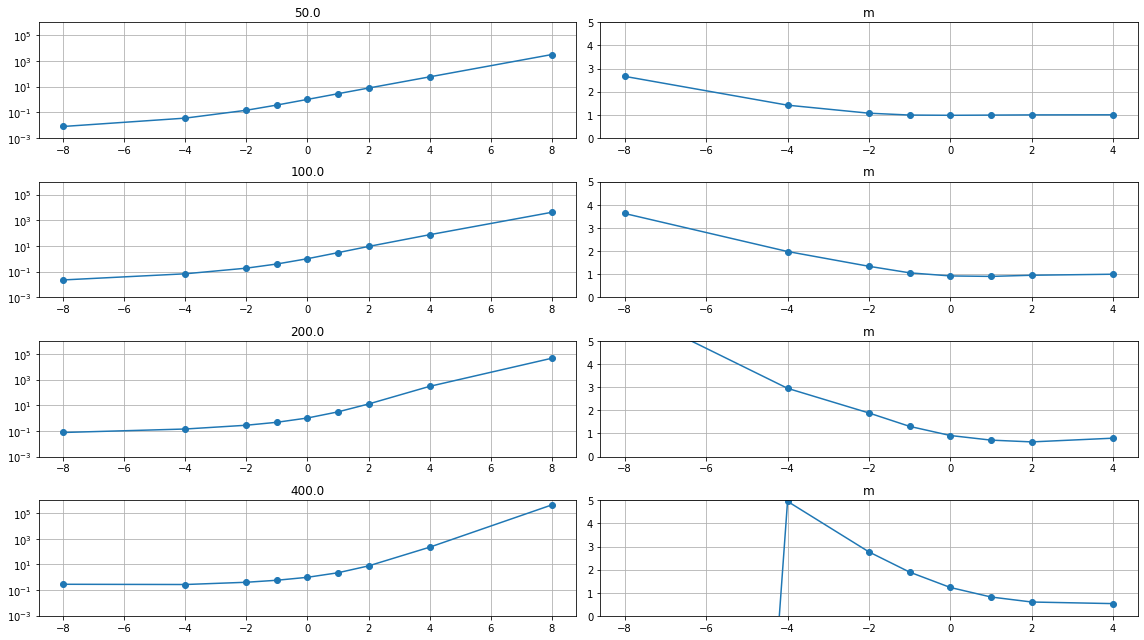

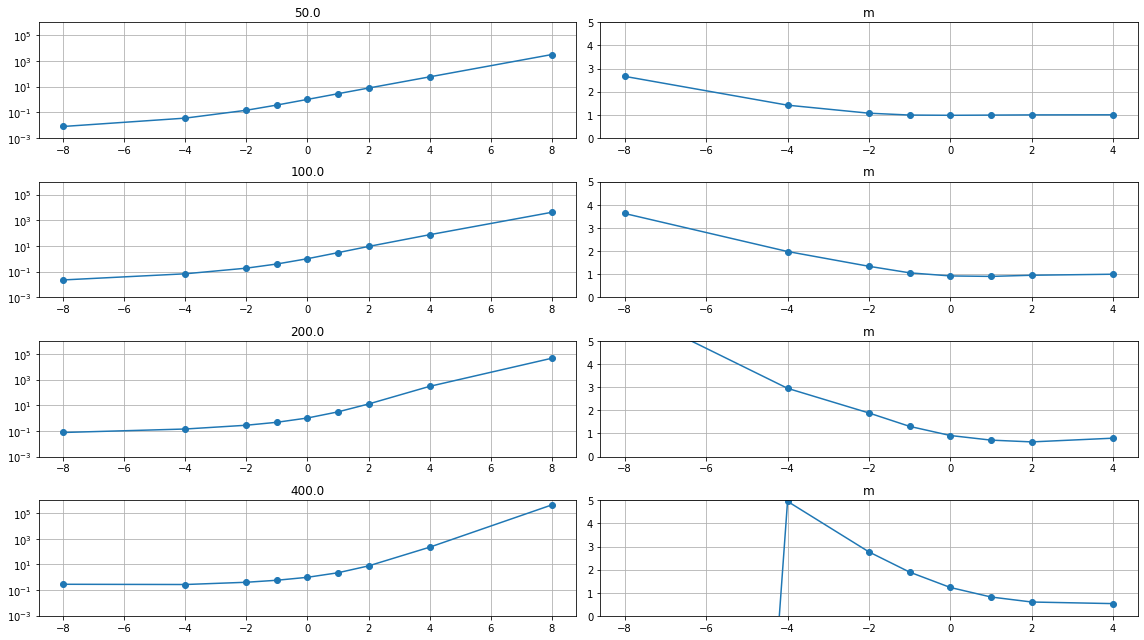

In [256]:
fig, axess = subplots(4,2,figsize = (16,9))

for ax_i, (R, calc_dF_grainsize) in enumerate(calc_dF.groupby('R')):
    axes =axess[ax_i,:]
    axes[0].set_title(R*1e9)
    flat_band = calc_dF_grainsize[calc_dF_grainsize['Einit_kT']==0].iloc[0]['current']
    res = flat_band/calc_dF_grainsize['current']
    v = calc_dF_grainsize['Einit_kT']
    axes[0].plot(v, res, 'o-', label = f'R={R*1e9}mn')
    axes[0].set_yscale('log')
    lnr = np.log([float(r) for r in res.values])
    axes[1].plot(v[0:-1], 1/(np.diff(lnr)/np.diff(v)),'o-')
    axes[1].set_ylim(0,5)
    axes[0].set_ylim(0.001,1e6)
    axes[0].grid(b=True)
    axes[1].grid(b=True)
    axes[1].set_title('m')
    
    
    axe.legend()
fig.tight_layout()
display(fig)

# Bibliography section

%%latex
\bibliographystyle{alphadin}
\bibliography{ipython}